# Analysis testing notebook

Here we test and look on different methods to analyze the data

Use the conda environment as explained in the `setup_instruction.md` file

In [44]:
# imports
import pandas as pd
import numpy as np
import os
import volue_insight_timeseries
import matplotlib.pyplot as plt

# imports from the api_functions.py file
from api_functions import initialize_session, get_curve, select_data, plot_dataframe

# Reload to get latest version with lag features
import importlib
import analysis_functions
importlib.reload(analysis_functions)
from analysis_functions import extract_features_df, analyze_day

### Small example

As you see we initialize the session, decide which curve to import and then get it and select the timeframe we want to analyze

Authentication succeeded. Session returned.
Curve fetched correctly! Curve ID: 20766, Type: TIME_SERIES
Selecting data from 2025-01-01 to 2026-01-10...


c:\Users\renma\miniconda3\envs\hackathon-energy\Lib\site-packages\volue_insight_timeseries\util.py:147: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return res.asfreq(self._map_freq(self.frequency))


Retrieved 8976 data points.
DatetimeIndex(['2025-01-01 00:00:00+01:00', '2025-01-01 01:00:00+01:00',
               '2025-01-01 02:00:00+01:00', '2025-01-01 03:00:00+01:00',
               '2025-01-01 04:00:00+01:00', '2025-01-01 05:00:00+01:00',
               '2025-01-01 06:00:00+01:00', '2025-01-01 07:00:00+01:00',
               '2025-01-01 08:00:00+01:00', '2025-01-01 09:00:00+01:00',
               ...
               '2026-01-09 14:00:00+01:00', '2026-01-09 15:00:00+01:00',
               '2026-01-09 16:00:00+01:00', '2026-01-09 17:00:00+01:00',
               '2026-01-09 18:00:00+01:00', '2026-01-09 19:00:00+01:00',
               '2026-01-09 20:00:00+01:00', '2026-01-09 21:00:00+01:00',
               '2026-01-09 22:00:00+01:00', '2026-01-09 23:00:00+01:00'],
              dtype='datetime64[ns, CET]', length=8976, freq='h')
Plotting data...


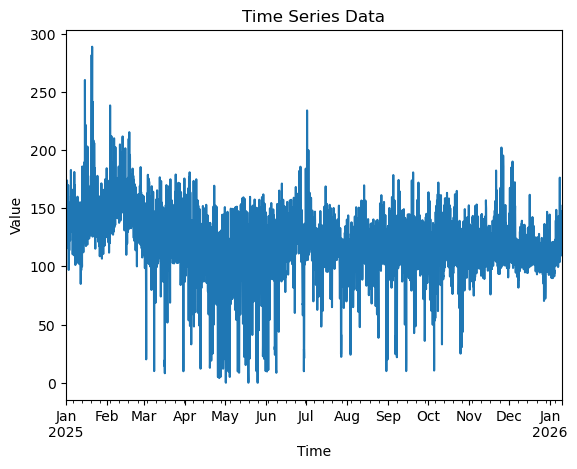

Plotting completed.


In [51]:

# initialize the session
session = initialize_session()

# define the curve name
curve_name = 'pri it spot €/mwh cet h a'

# get the curve object
curve = get_curve(session, curve_name)
# select data
data_df = select_data(curve, data_from='2025-01-01', data_to='2026-01-10')
# print(data_df)
print(data_df.index)
# plot the data
plot_dataframe(data_df)

### Analyze day compared to previous month


In [73]:
features_dday= analyze_day(
    data_df,
    day="2025-10-31",
    w=48
)

print(features_dday)    

                           pri it spot €/mwh cet h a_mean  \
2025-10-31 00:00:00+00:00                       -0.389505   
2025-10-31 01:00:00+00:00                       -0.460461   
2025-10-31 02:00:00+00:00                       -0.661721   
2025-10-31 03:00:00+00:00                       -0.718769   
2025-10-31 04:00:00+00:00                       -0.654220   
2025-10-31 05:00:00+00:00                       -0.538737   
2025-10-31 06:00:00+00:00                       -0.335343   
2025-10-31 07:00:00+00:00                        0.000765   
2025-10-31 08:00:00+00:00                        0.056766   
2025-10-31 09:00:00+00:00                        0.004886   
2025-10-31 10:00:00+00:00                        0.074910   
2025-10-31 11:00:00+00:00                       -0.230097   
2025-10-31 12:00:00+00:00                       -0.404498   
2025-10-31 13:00:00+00:00                       -0.560841   
2025-10-31 14:00:00+00:00                       -0.711819   
2025-10-31 15:00:00+00:0

###


## Get value of interest

#### Hourly Rolling Features (from extract_features_df on STL residuals)
    {col}_mean              : Rolling mean over w hours (baseline level)
    {col}_std               : Rolling std over w hours (short-term volatility)
    {col}_mad               : Median Absolute Deviation (robust to outliers)
    {col}_q25               : 25th percentile over w hours
    {col}_q75               : 75th percentile over w hours
    {col}_iqr               : Inter-quartile range (robust spread metric)
    {col}_z_abs             : Absolute z-score (how many std from mean)
    {col}_anomaly_rate      : % of hours in window with |z| > z_thr (default 3.0)
    {col}_rz_abs            : Robust z-score using MAD (resistant to extreme values)
    {col}_vol_rolling       : Rolling volatility (= std)
    {col}_vol_ewma          : Exponential moving avg of absolute deviations (recent vol emphasis)
    {col}_acf1              : Autocorrelation at lag 1 (t vs t-1)
    {col}_acf2              : Autocorrelation at lag 2 (t vs t-2)
    {col}_lag24             : Price value from 24 hours ago
    {col}_lag168            : Price value from 168 hours ago (7 days)
    {col}_lag24_delta       : Price change over past 24 hours (t - t-24)
    {col}_lag168_delta      : Price change over past 168 hours (t - t-168)
    {col}_dow_hour_z        : Z-score normalized by day-of-week + hour-of-day baseline
                              (removes diurnal/weekly seasonality)
    {col}_mean_shift        : Absolute change in rolling mean (regime change signal)
    
#### Calendar Context
    weekday                 : Day of week (0=Monday, 1=Tuesday, ..., 6=Sunday)
    hour                    : Hour of day (0=00:00, 1=01:00, ..., 23=23:00)
    
    === Day-Level Statistics ===
    {col}_day_mean          : Average price for the target day
    {col}_day_min           : Minimum price during the target day
    {col}_day_max           : Maximum price during the target day
    {col}_day_q10           : 10th percentile of prices that day
    {col}_day_q50           : Median price that day
    {col}_day_q90           : 90th percentile of prices that day
    
#### Price Regime Indicators
    {col}_neg_share         : Share of hours with negative prices (0.0 to 1.0)
    {col}_spike_share       : Share of hours exceeding 30-day 95th percentile
    
#### Intra-Day Volatility
    {col}_ramp_mean         : Average hour-to-hour price change
    {col}_ramp_std          : Volatility of hour-to-hour changes
    {col}_ramp_max_abs      : Largest single-hour price jump (absolute value)
    
#### Lag-Based Momentum & Seasonality 
    {col}_lag24_mean        : Average price 24 hours ago (yesterday, same time)
    {col}_lag168_mean       : Average price 168 hours ago (7 days ago, same weekday)
    {col}_day_vs_lag24      : Today's avg - Yesterday's avg (day momentum)
    {col}_day_vs_lag168     : Today's avg - Last week's avg (weekly seasonality)

In [78]:
hour = 0


min_price = features_dday['pri it spot €/mwh cet h a_day_mean'].iloc[hour]
print(min_price)

124.42437440000002
